<div align="center">
    <h1> </h1>
    <h1>Deep Learning Project</h1>
    <h2>Skin Disease Classification</h2>
    <h3>Reza Nasirian</h3>
    <h3>Bahar Mashhadi</h3>
</div>



---


## Objective
This notebook develops and trains multiple deep learning models to classify and generate skin disease images across 9 categories.
The models include:

1. **CNN Model**: A baseline convolutional neural network for classification.
2. **CNN with Pretrained Model (MobileNetV2)**: Using transfer learning with MobileNetV2 to improve performance.
3. **Fine-tuned CNN with Pretrained Model**: Optimizing transfer learning by fine-tuning.
4. **GANs**: Create new skin disease images using Generative Adversarial Networks (GANs).
5. **DCGANs**: Improved GANs using convolutional layers for higher-quality image generation.
6. **Autoencoder**: Build a model to compress and reconstruct skin disease images.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libarary

In [6]:
import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
from IPython import display
import imageio
import zipfile
import os
from google.colab import drive
import pickle

# Keras layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam


# Pre-trained models
from tensorflow.keras.applications import MobileNetV2


# Connect google drive

In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extract Data

In [9]:
zip_file_path = '/content/drive/MyDrive/resized.zip'
extract_folder = '/content/data/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

os.listdir(extract_folder)

['resized']

In [10]:
batch_size = 128
image_height = 152
image_width = 152

# Load Data

### Load and Preprocess Training Data from Directory

In [11]:
path = '/content/data/resized'

data_dir = pathlib.Path(path).with_suffix('')

train_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2 ,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size

)

Found 22982 files belonging to 9 classes.
Using 18386 files for training.


### Load and Preprocess Validation Data from Directory

In [12]:
validation_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 22982 files belonging to 9 classes.
Using 4596 files for validation.


## Explore and Visualize Training Data

### Visualizing Class Distribution: Bar Chart and Pie Chart

In [ ]:
class_counts = {class_name: 0 for class_name in train_data.class_names}

for _, labels in train_data:
    for label in labels.numpy():
        class_counts[train_data.class_names[label]] += 1

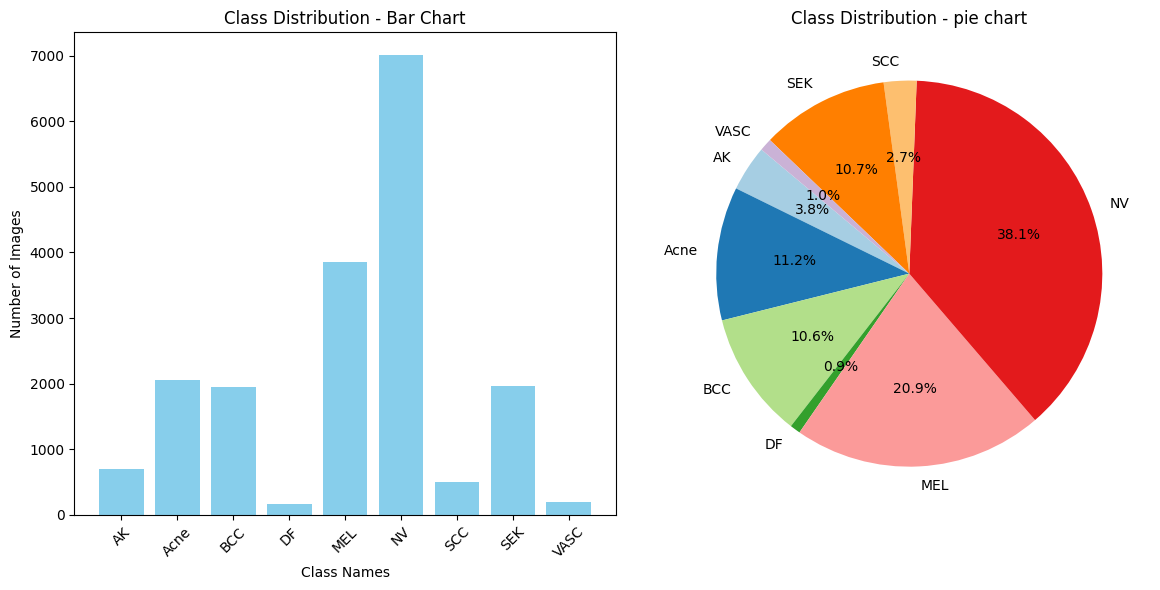

In [ ]:
class_names = list(class_counts.keys())
counts = list(class_counts.values())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(class_names, counts, color='skyblue')
axes[0].set_title("Class Distribution - Bar Chart")
axes[0].set_xlabel("Class Names")
axes[0].set_ylabel("Number of Images")
axes[0].tick_params(axis='x', rotation=45)

axes[1].pie(counts, labels=class_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
axes[1].set_title("Class Distribution - pie chart")

plt.tight_layout()
plt.show()

### Display a Sample Image from Each Class

In [ ]:
class_name = train_data.class_names

class_shows= [False for classn in class_name]
showed_image = []
showed_label = []

for image, label in train_data.take(1):
    for i in range(len(image)):

        current_class = class_name[label[i].numpy()]

        if not class_shows[label[i].numpy()]:
            showed_image.append(image[i].numpy())
            showed_label.append(current_class)
            class_shows[label[i].numpy()] = True

        if all(class_shows):
            break

    if all(class_shows):
        break
print(showed_label)

['MEL', 'NV', 'SEK', 'Acne', 'BCC', 'AK', 'VASC', 'SCC', 'DF']


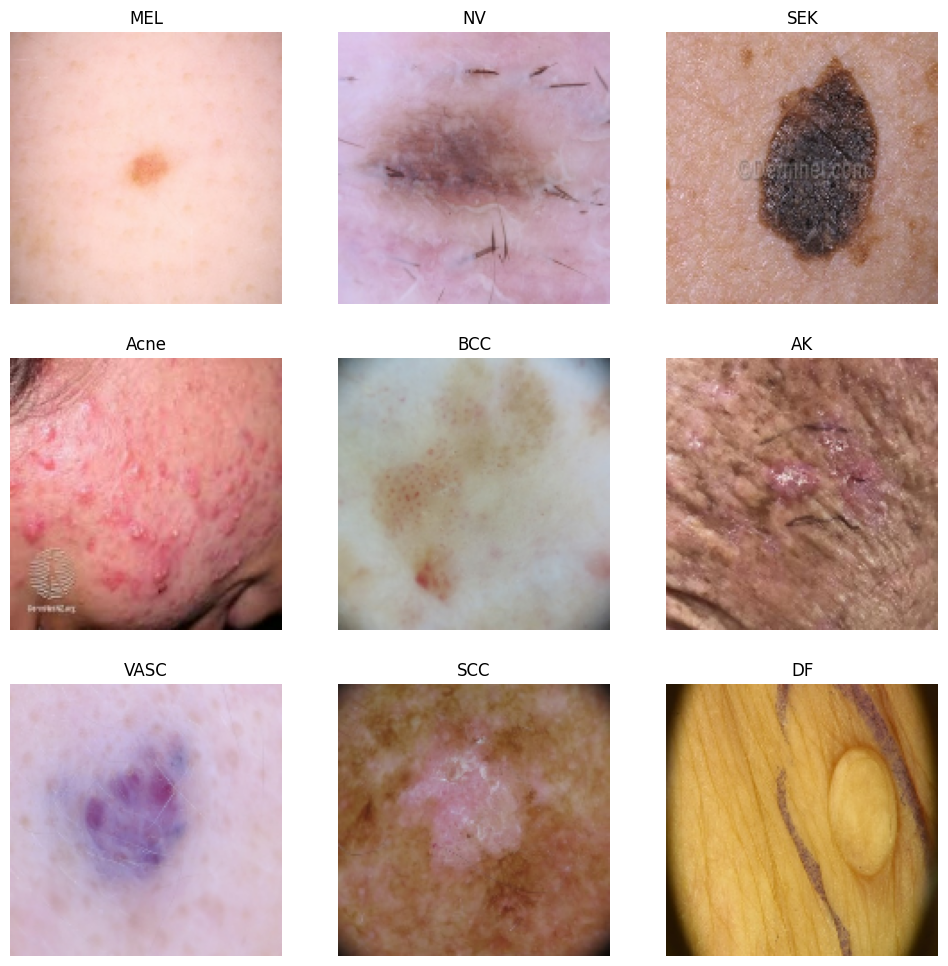

In [ ]:
plt.figure(figsize=(12,12))
for i, (img, label) in enumerate(zip(showed_image, showed_label)):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img.astype("uint8"))
    ax.set_title(label)
    ax.axis('off')

## Normalize and One-Hot Encode Training and Validation Data

In [13]:
train_datanorm = train_data.map(lambda x, y: (x / 255.0,tf.one_hot(y, depth=9) ))
validation_datanorm = validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, depth=9)))
# print(f"Number of training batches: {len(list(train_datanorm))}")
# print(f"Number of validation batches: {len(list(validation_datanorm))}")


# CNN Model

## Build and Compile CNN Model

In [12]:
CnnModel = Sequential([
    Input(shape=(152, 152, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

CnnModel.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
CnnModel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 73, 73, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       5,308,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,328,457 (20.33 MB)

 Trainable params: 5,328,457 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model with Early Stopping for Validation Loss

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
CnnModel_history = CnnModel.fit(
    train_datanorm,
    epochs=20,
    validation_data=validation_datanorm,
    callbacks=[early_stopping]
)

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.4052 - loss: 1.8208 - val_accuracy: 0.5855 - val_loss: 1.1565
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 31s 216ms/step - accuracy: 0.5356 - loss: 1.2730 - val_accuracy: 0.6419 - val_loss: 1.0043
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.5908 - loss: 1.1205 - val_accuracy: 0.6540 - val_loss: 0.9607
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 184ms/step - accuracy: 0.6214 - loss: 1.0432 - val_accuracy: 0.6810 - val_loss: 0.8804
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - accuracy: 0.6404 - loss: 0.9914 - val_accuracy: 0.6971 - val_loss: 0.8606
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 187ms/step - accuracy: 0.6527 - loss: 0.9472 - val_accuracy: 0.7045 - val_loss: 0.8035
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.6687 - loss: 0.9048 - val_accuracy: 0.7224 - val_loss: 0.7775
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - accuracy: 0.6812 - loss: 0

## Save CNN Model Accuracy and Loss

In [14]:
CnnModel.save('cnn_model.h5')
with open('CnnModel.pkl', 'wb') as file:
  pickle.dump(CnnModel_history.history , file)

## Visualize Training/Validation Accuracy and Loss Curves

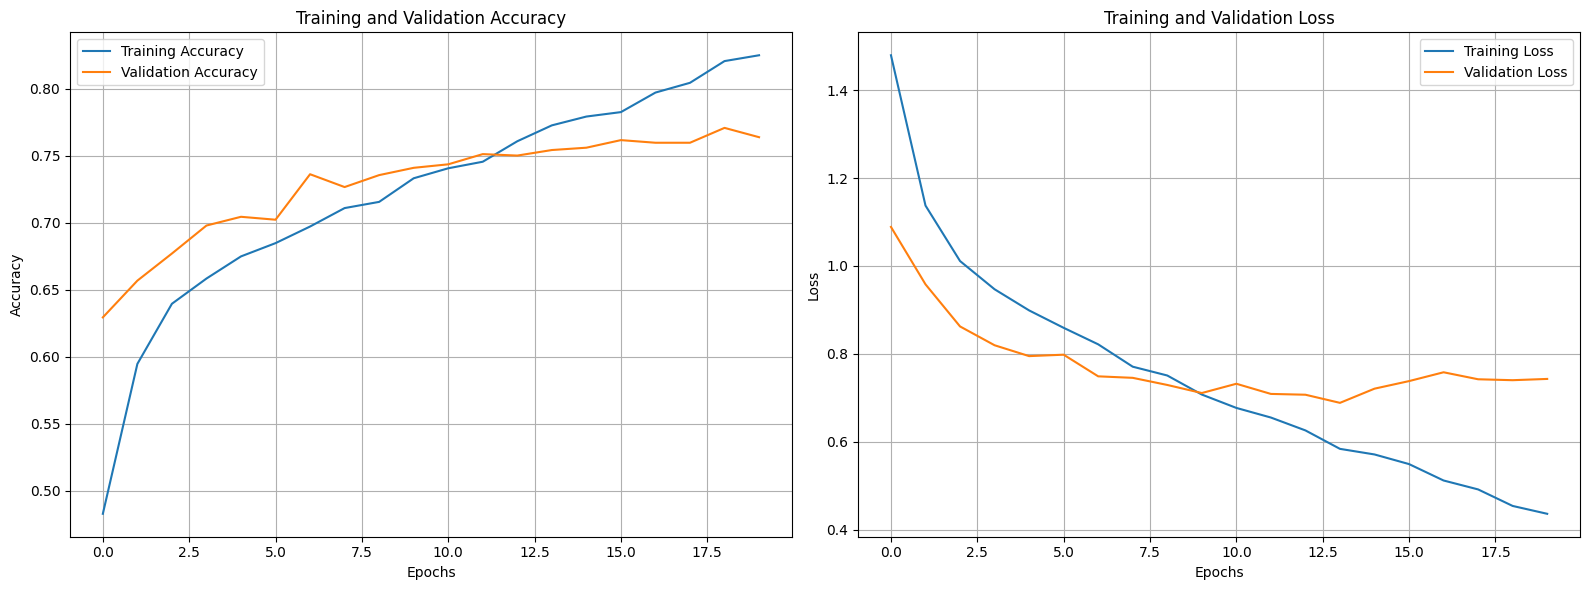

In [ ]:
with open('training_history.pkl','rb') as file :
  CnnModel_history = pickle.load(file)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(CnnModel_history['accuracy'], label='Training Accuracy')
axes[0].plot(CnnModel_history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(CnnModel_history['loss'], label='Training Loss')
axes[1].plot(CnnModel_history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step
[4 5 4 ... 2 5 5]
[4 2 1 ... 5 5 5]


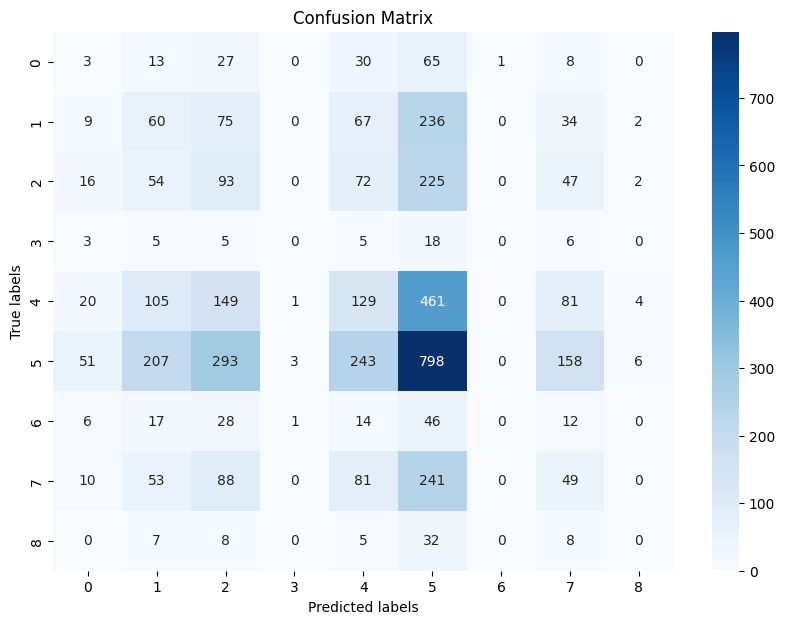

In [20]:
savedCnnModel = load_model('/content/drive/MyDrive/cnn_model.h5')

predictions = savedCnnModel.predict(validation_datanorm)
predictions = np.argmax(predictions, axis=1)
print(predictions)
true_labels = []
for images, labels in validation_datanorm:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)
true_labels = np.argmax(true_labels, axis=1)

print(true_labels)
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#Pretrain Model


In [21]:
batch_size = 128
image_height_p = 224
image_width_p = 224

### Load and Preprocess Training Data from Directory

In [22]:
path = '/content/data/resized'

data_dir = pathlib.Path(path).with_suffix('')
train_data_p = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2 ,
  subset="training",
  seed=123,
  image_size=(image_height_p, image_width_p),
  batch_size=batch_size

)

Found 22982 files belonging to 9 classes.
Using 18386 files for training.


### Load and Preprocess Validation Data from Directory

In [23]:
validation_data_p = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height_p, image_width_p),
  batch_size=batch_size)

Found 22982 files belonging to 9 classes.
Using 4596 files for validation.


## Normalize and One-Hot Encode Training and Validation Data

In [24]:
train_datanorm_p = train_data_p.map(lambda x, y: (x / 255.0,tf.one_hot(y, depth=9) ))
validation_datanorm_p = validation_data_p.map(lambda x, y: (x / 255.0, tf.one_hot(y, depth=9)))

## Build and Compile Pretrained MobileNetV2 Model

In [25]:
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in mobilenet.layers:
    layer.trainable = False

x = mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1280, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(640, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(9, activation='softmax')(x)
Pretrainmodel = Model(inputs=mobilenet.input, outputs=x)

Pretrainmodel.compile(optimizer = Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
Pretrainmodel.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,730,953 (18.05 MB)

 Trainable params: 2,469,129 (9.42 MB)

 Non-trainable params: 2,261,824 (8.63 MB)

## Train Pretrained MobileNetV2 Model with Early Stopping

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
Pretrainmodel_history = Pretrainmodel.fit(
    train_datanorm_p,
    epochs=40,
    validation_data=validation_datanorm_p,
    callbacks=[early_stopping]
)

Epoch 1/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 86s 464ms/step - accuracy: 0.2010 - loss: 3.0450 - val_accuracy: 0.5683 - val_loss: 1.3817
Epoch 2/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 270ms/step - accuracy: 0.4019 - loss: 2.1288 - val_accuracy: 0.6310 - val_loss: 1.1439
Epoch 3/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 270ms/step - accuracy: 0.4757 - loss: 1.8299 - val_accuracy: 0.6567 - val_loss: 1.0543
Epoch 4/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.5244 - loss: 1.6687 - val_accuracy: 0.6752 - val_loss: 1.0041
Epoch 5/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 45s 283ms/step - accuracy: 0.5520 - loss: 1.5407 - val_accuracy: 0.6832 - val_loss: 0.9610
Epoch 6/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - accuracy: 0.5748 - loss: 1.4384 - val_accuracy: 0.6906 - val_loss: 0.9282
Epoch 7/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 274ms/step - accuracy: 0.5978 - loss: 1.3580 - val_accuracy: 0.6995 - val_loss: 0.9016
Epoch 8/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 244ms/step - accuracy: 0.6096 - loss: 1

## Save Pretrained MobileNetV2 Model accuracy and loss

In [27]:
Pretrainmodel.save('Pretrainmodel.h5')
with open('Pretrainmodel_history.pkl', 'wb') as file:
  pickle.dump(Pretrainmodel_history.history , file)

## Visualize Training/Validation Accuracy and Loss Before Fine-Tuning

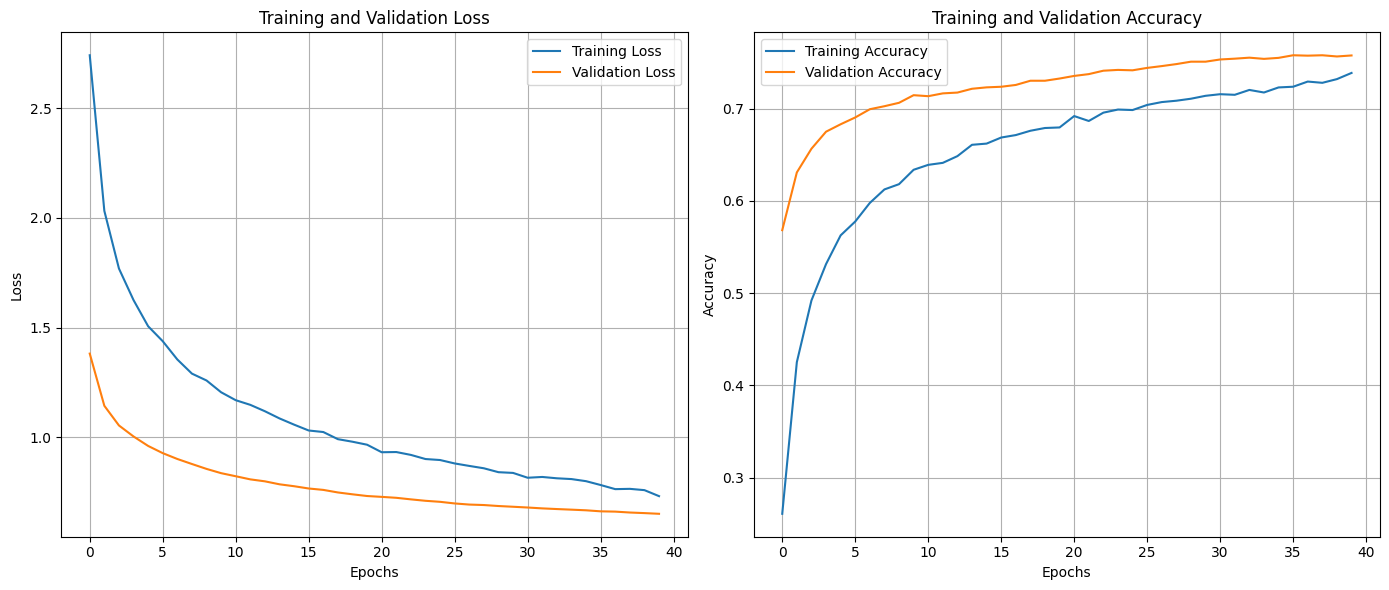

In [28]:
with open('Pretrainmodel_history.pkl','rb') as file :
  Pretrainmodel_history = pickle.load(file)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(Pretrainmodel_history['loss'], label='Training Loss')
axes[0].plot(Pretrainmodel_history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(Pretrainmodel_history['accuracy'], label='Training Accuracy')
axes[1].plot(Pretrainmodel_history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step
[4 4 5 ... 1 5 2]
[5 5 2 ... 5 5 5]


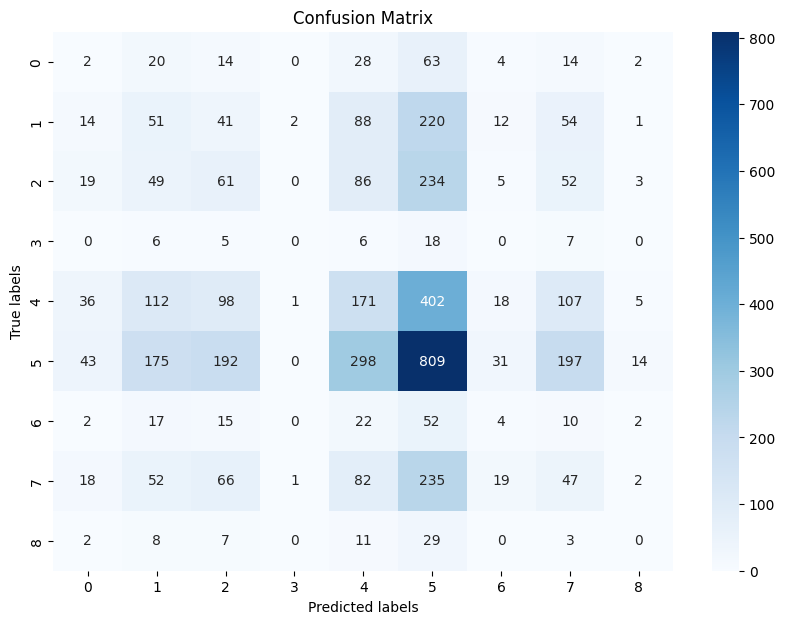

In [31]:
savedPreTrainedModel = load_model('Pretrainmodel.h5')

predictions = savedPreTrainedModel.predict(validation_datanorm_p)
predictions = np.argmax(predictions, axis=1)
print(predictions)
true_labels = []
for images, labels in validation_datanorm_p:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)
true_labels = np.argmax(true_labels, axis=1)

print(true_labels)
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Unfreeze Last Layer of Pretrained MobileNetV2 Model

In [ ]:
for layer in mobilenet.layers[-10:]:
    layer.trainable = True
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
Pretrainmodel.compile(optimizer = Adam(learning_rate=1e-5) , loss = 'categorical_crossentropy', metrics = ['accuracy'])

finetune_history = Pretrainmodel.fit(
    train_datanorm_p,
    epochs=30,
    validation_data=validation_datanorm_p,
    callbacks=[early_stopping]
)

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 92s 443ms/step - accuracy: 0.1782 - loss: 3.1193 - val_accuracy: 0.5117 - val_loss: 1.6044
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 35s 245ms/step - accuracy: 0.4094 - loss: 2.0756 - val_accuracy: 0.5977 - val_loss: 1.2609
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - accuracy: 0.5067 - loss: 1.7262 - val_accuracy: 0.6351 - val_loss: 1.1621
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - accuracy: 0.5590 - loss: 1.5213 - val_accuracy: 0.6549 - val_loss: 1.1239
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.5969 - loss: 1.3866 - val_accuracy: 0.6715 - val_loss: 1.0635
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 273ms/step - accuracy: 0.6217 - loss: 1.2785 - val_accuracy: 0.6869 - val_loss: 1.0070
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 274ms/step - accuracy: 0.6393 - loss: 1.1895 - val_accuracy: 0.6993 - val_loss: 0.9644
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 257ms/step - accuracy: 0.6478 - loss: 1

## Save Pretrained MobileNetV2 Model accuracy and loss

In [ ]:
Pretrainmodel.save('Pretrainmodel.h5')
with open('finetune_history.pkl', 'wb') as file:
  pickle.dump(finetune_history.history , file)

## Visualize Training/Validation Accuracy and Loss After Fine-Tuning

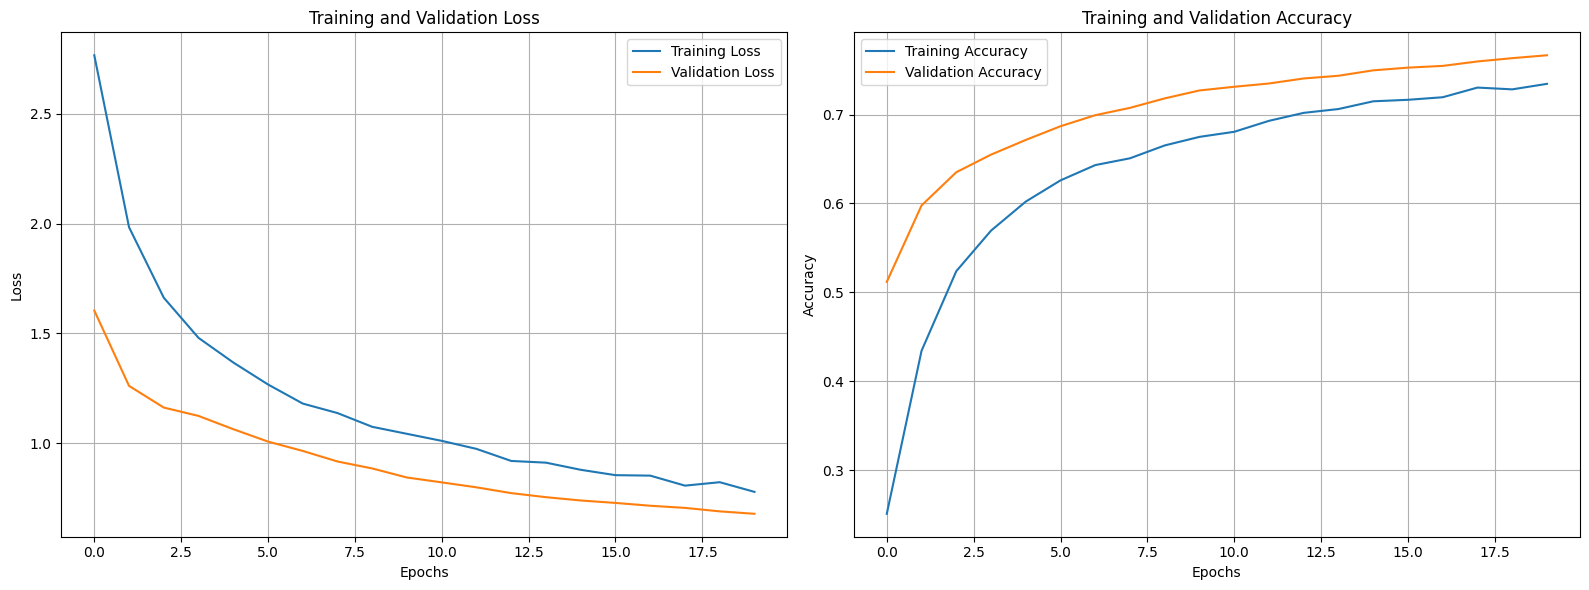

In [ ]:
with open('finetune_history.pkl','rb') as file :
  finetune_history = pickle.load(file)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(finetune_history['loss'], label='Training Loss')
axes[0].plot(finetune_history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(finetune_history['accuracy'], label='Training Accuracy')
axes[1].plot(finetune_history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Comparison of Training and Validation Performance

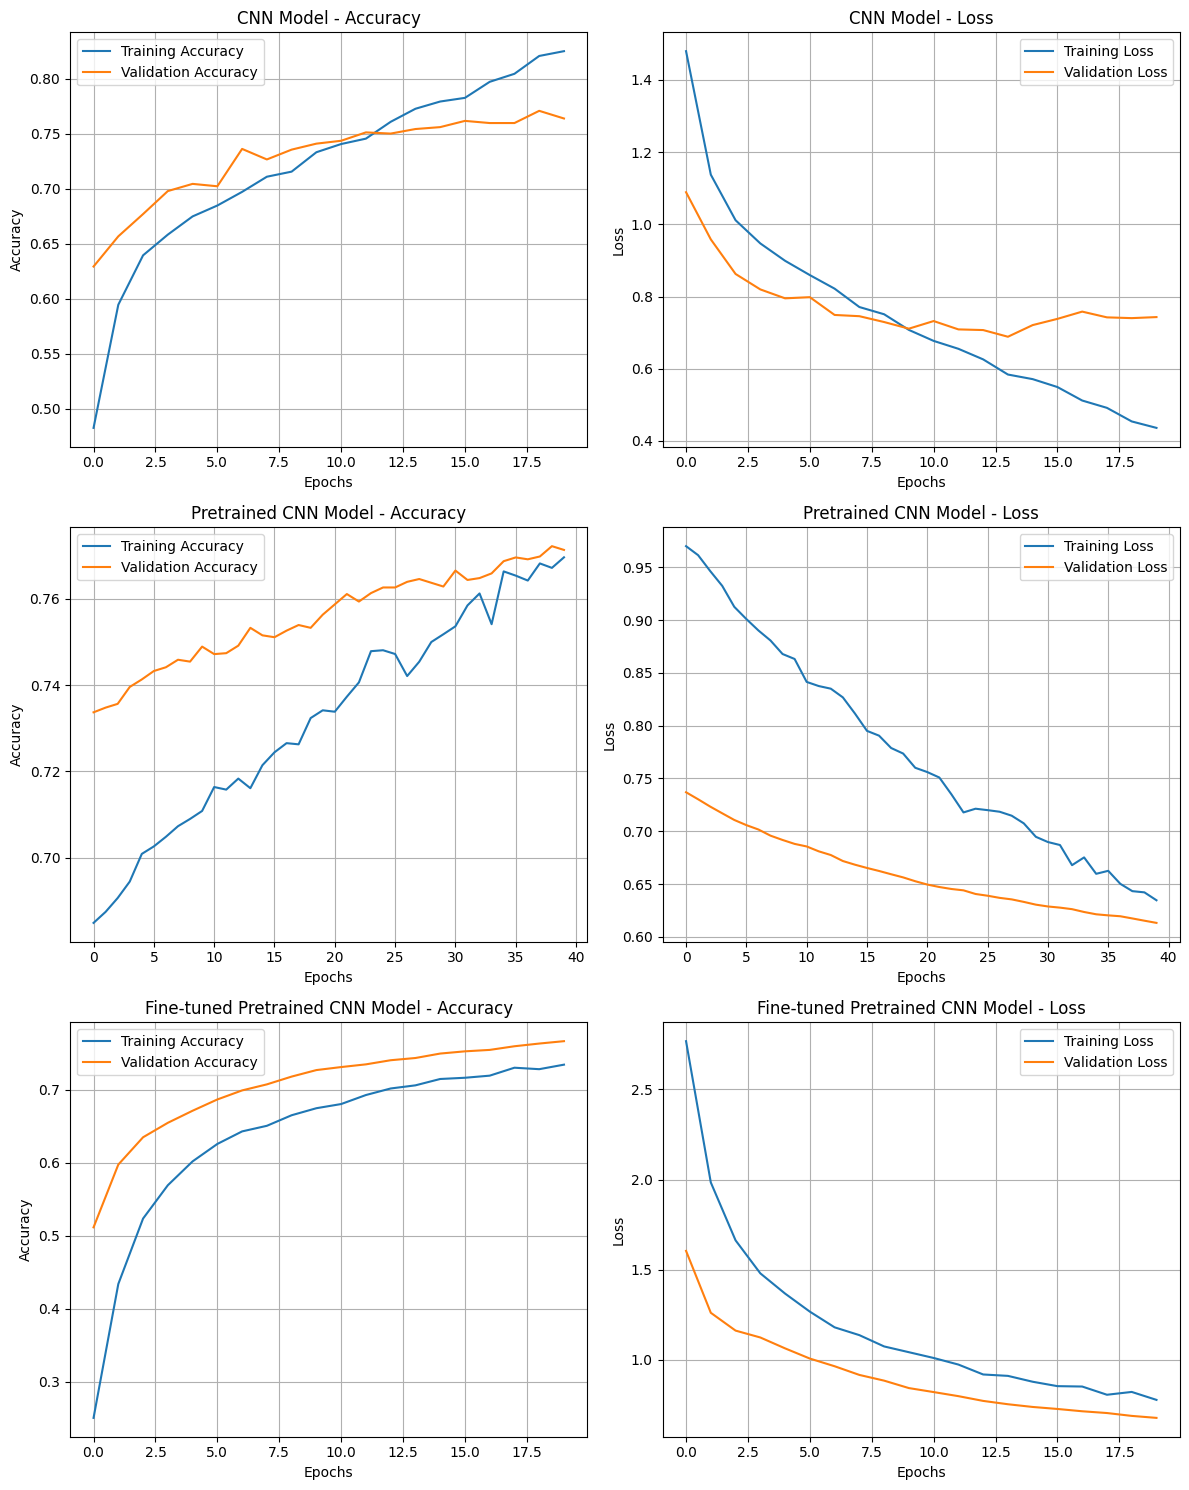

In [ ]:
with open('/content/drive/MyDrive/Pretrainmodel_history.pkl','rb') as file :
  Pretrainmodel_history = pickle.load(file)
with open('/content/drive/MyDrive/cnn_model.pkl','rb') as file :
  CnnModel_history = pickle.load(file)
with open('/content/drive/MyDrive/finetune_history.pkl','rb') as file :
  finetune_history = pickle.load(file)

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# CNN Model
axes[0, 0].plot(CnnModel_history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(CnnModel_history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('CNN Model - Accuracy')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(CnnModel_history['loss'], label='Training Loss')
axes[0, 1].plot(CnnModel_history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('CNN Model - Loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Pretrained CNN Model
axes[1, 0].plot(Pretrainmodel_history['accuracy'], label='Training Accuracy')
axes[1, 0].plot(Pretrainmodel_history['val_accuracy'], label='Validation Accuracy')
axes[1, 0].set_title('Pretrained CNN Model - Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(Pretrainmodel_history['loss'], label='Training Loss')
axes[1, 1].plot(Pretrainmodel_history['val_loss'], label='Validation Loss')
axes[1, 1].set_title('Pretrained CNN Model - Loss')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Fine-tuned Pretrained CNN Model
axes[2, 0].plot(finetune_history['accuracy'], label='Training Accuracy')
axes[2, 0].plot(finetune_history['val_accuracy'], label='Validation Accuracy')
axes[2, 0].set_title('Fine-tuned Pretrained CNN Model - Accuracy')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()
axes[2, 0].grid(True)

axes[2, 1].plot(finetune_history['loss'], label='Training Loss')
axes[2, 1].plot(finetune_history['val_loss'], label='Validation Loss')
axes[2, 1].set_title('Fine-tuned Pretrained CNN Model - Loss')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

# **GANS Model**

## Set Hyperparameters and Configuration

In [ ]:
total_epoch = 30
batch_size = 32
learning_rate = 0.0001
n_noise = 128
image_h, image_w, channels = 152, 152, 3


In [ ]:
train_datanorm = train_data.map(lambda x, y: ((x / 127) - 1 ,tf.one_hot(y, depth=9) ))
validation_datanorm = validation_data.map(lambda x, y: ((x / 127 )- 1, tf.one_hot(y, depth=9)))

## Build Generator Model for GAN

In [ ]:
def build_generator(z_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_dim=z_dim),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(image_h * image_w * channels, activation='tanh'),
        tf.keras.layers.Reshape((image_h, image_w, channels))
    ])
    return model

## Build Discriminator Model for GAN

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(image_h, image_w, channels)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

## Initialize GAN Components: Loss Function, Optimizers, and Models

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
generator = build_generator(n_noise)
discriminator = build_discriminator()


optimizer_G = tf.keras.optimizers.Adam(learning_rate)
optimizer_D = tf.keras.optimizers.Adam(learning_rate)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Define GAN Training Step with Gradient Descent

In [ ]:
@tf.function
def train_step(real_images, noise):
    with tf.GradientTape() as tape_D, tf.GradientTape() as tape_G:

        real_output = discriminator(real_images, training=True)
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)

        d_loss_real = loss_fn(tf.ones_like(real_output), real_output)
        d_loss_fake = loss_fn(tf.zeros_like(fake_output), fake_output)
        d_loss = d_loss_real + d_loss_fake

        g_loss = loss_fn(tf.ones_like(fake_output), fake_output)

    grads_D = tape_D.gradient(d_loss, discriminator.trainable_variables)
    grads_G = tape_G.gradient(g_loss, generator.trainable_variables)
    optimizer_D.apply_gradients(zip(grads_D, discriminator.trainable_variables))
    optimizer_G.apply_gradients(zip(grads_G, generator.trainable_variables))

    return d_loss, g_loss, fake_images

## Initialize Checkpoint for Saving Model States During Training

In [ ]:
checkpoint_dir = './training_checkpointsGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=optimizer_G,
                                 discriminator_optimizer=optimizer_D,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate and Save Images from GAN at Each Epoch

In [ ]:
images_per_epoch = []
def save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0
    images_per_epoch.append(predictions.numpy())



## Train GAN and Log Losses and Generated Images

In [ ]:
g_losses = []
d_losses = []
n_noise = 100
def train(dataset, epochs):
  seed = np.random.normal(0, 1, (16, n_noise))

  for epoch in range(epochs):
    start = time.time()

    for batch_real_images, _ in train_datanorm:
        noise = np.random.normal(0, 1, (batch_real_images.shape[0], n_noise))

        d_loss, g_loss, generated_images = train_step(batch_real_images, noise)
    g_losses.append(g_loss.numpy())
    d_losses.append(d_loss.numpy())
    save_images(generator, epoch + 1, seed)

    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print(f"Epoch {epoch + 1} completed in {time.time() - start:.2f} seconds")

  num_epochs = len(images_per_epoch)

  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_epochs + 1), g_losses, label='Generator Loss', color='blue')
  plt.plot(range(1, num_epochs + 1), d_losses, label='Discriminator Loss', color='orange')
  plt.title("Generator and Discriminator Losses Over Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure(figsize=(10, num_epochs * 2))
  for i, images in enumerate(images_per_epoch):
      for j in range(images.shape[0]):
          plt.subplot(num_epochs, images.shape[0], i * images.shape[0] + j + 1)
          plt.imshow(images[j])
          plt.axis('off')
      plt.suptitle(f"Generated Images from Epochs 1 to {num_epochs}")
  plt.tight_layout()
  plt.show()


Epoch 1 completed in 41.04 seconds
Epoch 2 completed in 20.49 seconds
Epoch 3 completed in 40.97 seconds
Epoch 4 completed in 20.54 seconds
Epoch 5 completed in 25.86 seconds
Epoch 6 completed in 22.33 seconds
Epoch 7 completed in 20.49 seconds
Epoch 8 completed in 21.20 seconds
Epoch 9 completed in 20.49 seconds
Epoch 10 completed in 23.94 seconds
Epoch 11 completed in 21.69 seconds
Epoch 12 completed in 20.56 seconds
Epoch 13 completed in 19.40 seconds
Epoch 14 completed in 19.12 seconds
Epoch 15 completed in 29.14 seconds
Epoch 16 completed in 20.89 seconds
Epoch 17 completed in 19.35 seconds
Epoch 18 completed in 19.01 seconds
Epoch 19 completed in 21.02 seconds
Epoch 20 completed in 31.35 seconds
Epoch 21 completed in 20.49 seconds
Epoch 22 completed in 21.21 seconds
Epoch 23 completed in 18.90 seconds
Epoch 24 completed in 20.49 seconds
Epoch 25 completed in 24.16 seconds
Epoch 26 completed in 20.48 seconds
Epoch 27 completed in 20.49 seconds
Epoch 28 completed in 19.12 seconds
E

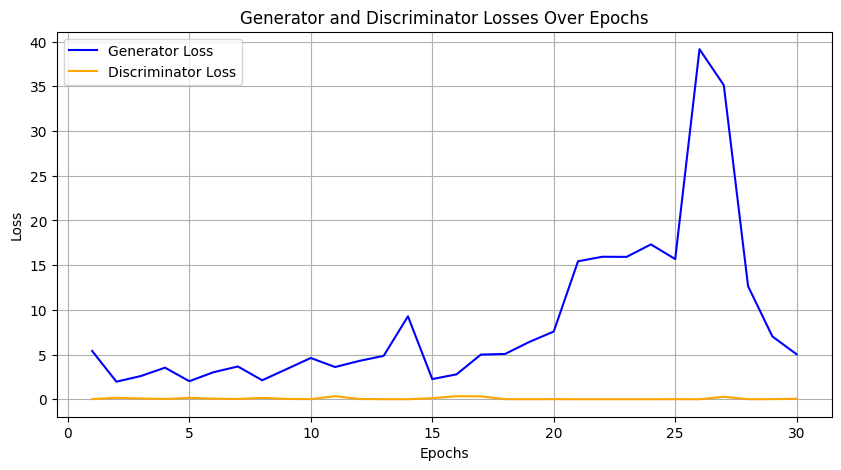

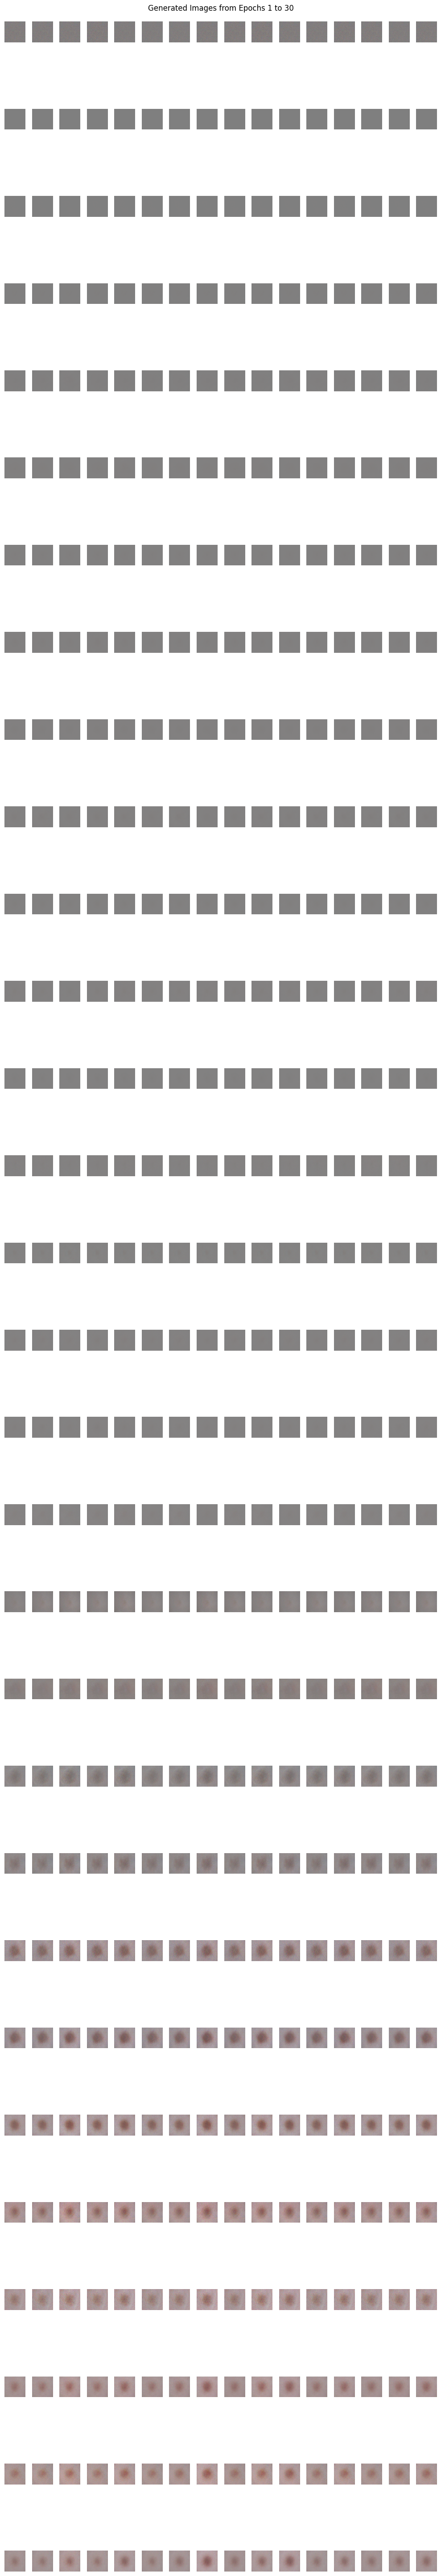

In [ ]:
train(train_datanorm, total_epoch)

# DCGANS Model

## Normalize Data and Apply One-Hot Encoding for Training and Validation

In [ ]:
train_datanorm = train_data.map(lambda x, y: ((x / 127) - 1 ,tf.one_hot(y, depth=9) ))
validation_datanorm = validation_data.map(lambda x, y: ((x / 127 )- 1, tf.one_hot(y, depth=9)))

## Build Generator Model for DCGAN

In [ ]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(38*38*128 , use_bias =False , input_shape= (100,), kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((38,38,128)))
    assert model.output_shape == (None, 38, 38, 128)

    model.add(layers.Conv2DTranspose(64 ,(5,5) , strides = (2,2) , padding = 'same' , use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 76, 76, 64)

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 152, 152, 32)


    model.add(layers.Conv2DTranspose(3 ,(5,5) , strides = (1,1) , padding = 'same' , use_bias = False, activation='tanh'))
    assert model.output_shape == (None, 152, 152, 3)

    return model


## Generate and Visualize an Image from Noise Using the Generator



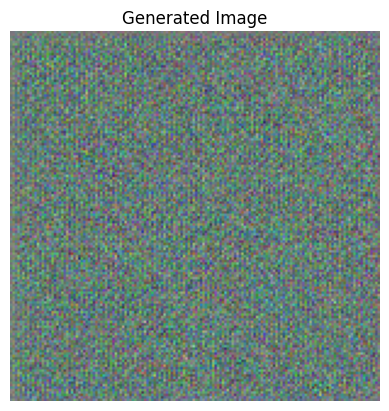

In [ ]:
generator = build_generator()
noise = tf.random.normal([1, 100], mean=0.0, stddev=1.0)
generated_images = generator(noise, training = False)
scaled_image = (generated_images[0] + 1) / 2
plt.imshow(scaled_image.numpy())

plt.axis("off")
plt.title("Generated Image")
plt.show()

## Build Discriminator Model for DCGAN

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[152,152,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation = 'sigmoid'))

    return model

## Define Loss Functions for Generator and Discriminator in DCGAN

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Set Hyperparameters for GAN Training

In [ ]:
EPOCHS = 30
noise_dim = 100
BUFFER_SIZE = 60000
BATCH_SIZE = 256
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])


## Initialize Optimizers for Generator and Discriminator

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator = build_generator()
discriminator = build_discriminator()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Define and Execute GAN Training Step with Gradient

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, generated_images


## Initialize Checkpoint for Saving Model States During Training

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate and Save Images from GAN at Each Epoch

In [ ]:
images_per_epochdc = []
def save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0
    images_per_epochdc.append(predictions.numpy())



## Train GAN and Save Checkpoints and Generated Images

In [ ]:
dcg_losses = []
dcd_losses = []
n_noise = 100
def train(dataset, epochs):
  seed = np.random.normal(0, 1, (16, n_noise))
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
       gen_loss, disc_loss, _ = train_step(image_batch)

    dcg_losses.append(gen_loss.numpy())
    dcd_losses.append(disc_loss.numpy())


    save_images(generator, epoch + 1, seed)

    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print(f"Epoch {epoch + 1} completed in {time.time() - start:.2f} seconds")

  num_epochs = len(images_per_epochdc)

  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_epochs + 1), dcg_losses, label='Generator Loss', color='blue')
  plt.plot(range(1, num_epochs + 1), dcd_losses, label='Discriminator Loss', color='orange')
  plt.title("Generator and Discriminator Losses Over Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure(figsize=(10, num_epochs * 2))
  for i, images in enumerate(images_per_epochdc):
      for j in range(images.shape[0]):
          plt.subplot(num_epochs, images.shape[0], i * images.shape[0] + j + 1)
          plt.imshow(images[j])
          plt.axis('off')
      plt.suptitle(f"Generated Images from Epochs 1 to {num_epochs}")
  plt.tight_layout()
  plt.show()

Epoch 1 completed in 158.37 seconds
Epoch 2 completed in 157.26 seconds
Epoch 3 completed in 156.96 seconds
Epoch 4 completed in 156.81 seconds
Epoch 5 completed in 163.80 seconds
Epoch 6 completed in 157.45 seconds
Epoch 7 completed in 157.07 seconds
Epoch 8 completed in 157.30 seconds
Epoch 9 completed in 157.27 seconds
Epoch 10 completed in 161.47 seconds
Epoch 11 completed in 157.32 seconds
Epoch 12 completed in 157.10 seconds
Epoch 13 completed in 157.30 seconds
Epoch 14 completed in 156.93 seconds
Epoch 15 completed in 158.31 seconds
Epoch 16 completed in 157.32 seconds
Epoch 17 completed in 157.32 seconds
Epoch 18 completed in 157.24 seconds
Epoch 19 completed in 157.19 seconds
Epoch 20 completed in 157.95 seconds
Epoch 21 completed in 157.15 seconds
Epoch 22 completed in 157.04 seconds
Epoch 23 completed in 157.26 seconds
Epoch 24 completed in 157.03 seconds
Epoch 25 completed in 158.07 seconds
Epoch 26 completed in 157.29 seconds
Epoch 27 completed in 157.16 seconds
Epoch 28 c

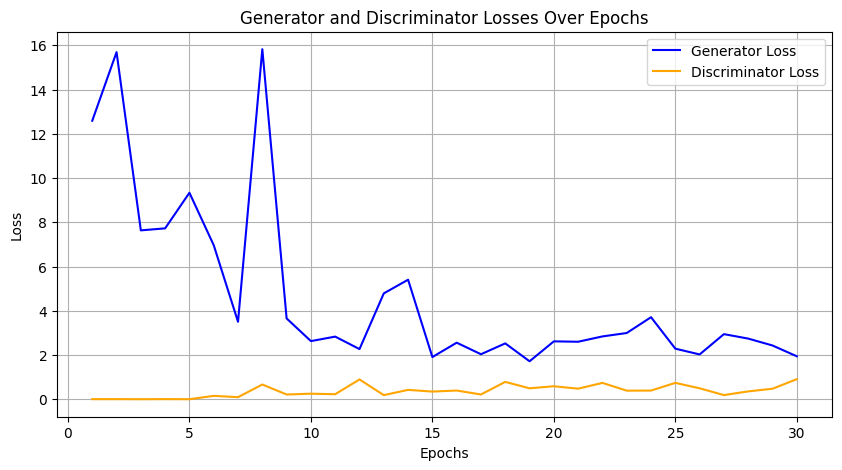

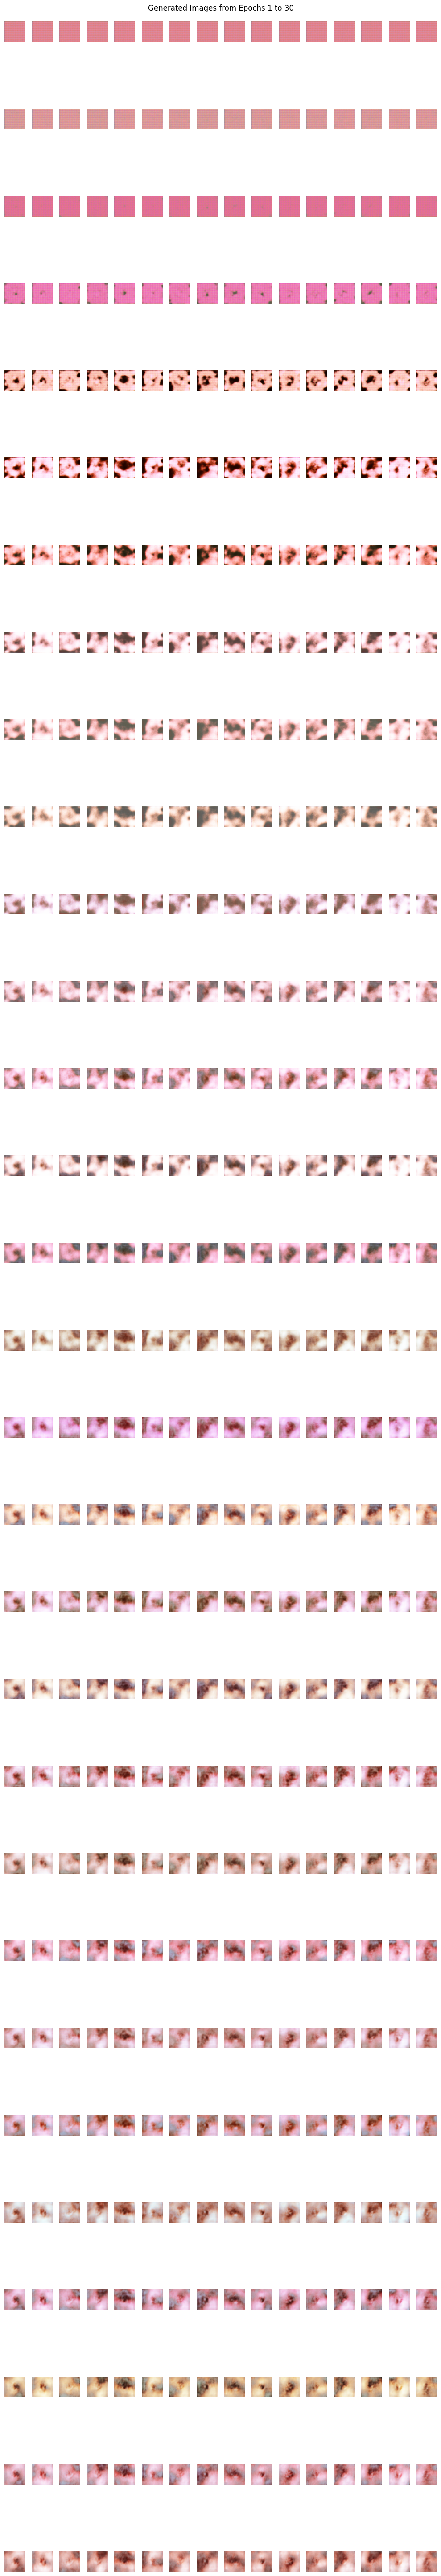

In [ ]:
train(train_datanorm, EPOCHS)

# Autoencoders

## Load and Preprocess Training and validation Data from Directory

In [ ]:
path = '/content/data/resized'

data_dir = pathlib.Path(path).with_suffix('')
Autoencoders_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode=None
)

Autoencoder_validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode=None  )

Found 22982 files.
Using 18386 files for training.
Found 22982 files.
Using 4596 files for validation.


## Normalize Training and Validation Data

In [ ]:
def normalize(image):
    return tf.cast(image, tf.float32) / 255.0

Autoencoders_train_data = Autoencoders_train_data.map(normalize)
Autoencoder_validation_data = Autoencoder_validation_data.map(normalize)

In [ ]:
def add_noise_tf(images, noise_factor=0.2):
    noise = noise_factor * tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=1.0, dtype=tf.float32)
    noisy_images = images + noise
    return tf.clip_by_value(noisy_images, 0.0, 1.0)

def noisy_dataset(dataset, noise_factor=0.2):
    return dataset.map(lambda x: (add_noise_tf(x, noise_factor), x))

noisy_train_data = noisy_dataset(Autoencoders_train_data)
noisy_validation_data = noisy_dataset(Autoencoder_validation_data)


## Build and Compile Autoencoder Model

In [ ]:
def build_autoencoder(input_shape=(152, 152, 3)):
    model = tf.keras.Sequential(name="Autoencoder")

    # --- Encoder ---
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # ----- Decoder -----
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same'))

    return model


In [ ]:
input_shape  = (152, 152 , 3)
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 152, 152, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 76, 76, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 76, 76, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 38, 38, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 19, 19, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 38, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 38, 38, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 76, 76, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 76, 76, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 152, 152, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 152, 152, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 50
checkpoint = ModelCheckpoint(
    "best_autoencoder.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1
)
history = autoencoder.fit(
    noisy_train_data,
    validation_data=noisy_validation_data,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - loss: 0.0180
Epoch 1: val_loss improved from inf to 0.00243, saving model to best_autoencoder.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 105s 592ms/step - loss: 0.0179 - val_loss: 0.0024
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - loss: 0.0023
Epoch 2: val_loss improved from 0.00243 to 0.00169, saving model to best_autoencoder.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 65s 453ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 0.0016
Epoch 3: val_loss improved from 0.00169 to 0.00150, saving model to best_autoencoder.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 80s 442ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.0015
Epoch 4: val_loss improved from 0.00150 to 0.00139, saving model to best_autoencoder.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 74s 516ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


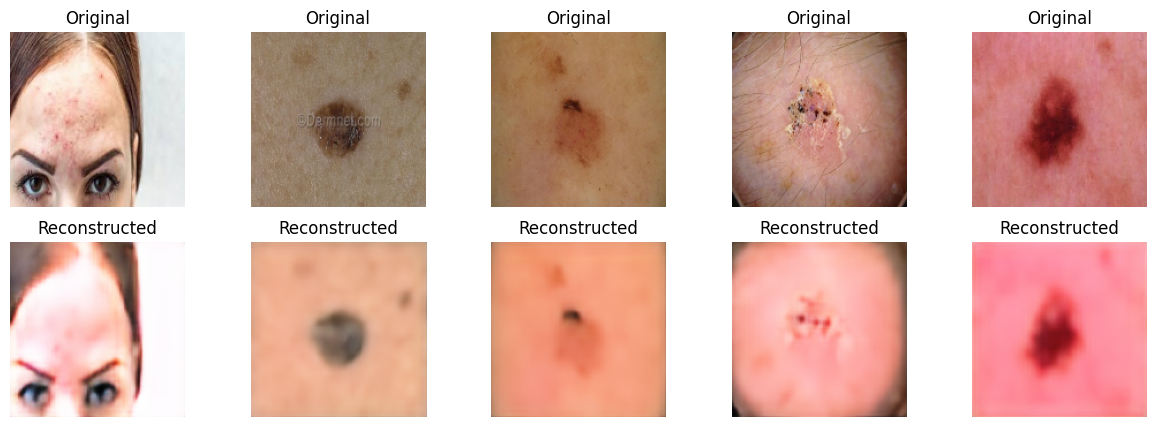

In [ ]:
def visualize_results(autoencoder, dataset, num_images=5):
    for batch in dataset.take(1):
        original_images = batch[:num_images]
        reconstructed_images = autoencoder.predict(original_images)

        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            plt.subplot(2, num_images, i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title("Original")
            plt.axis("off")

            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(reconstructed_images[i])
            plt.title("Reconstructed")
            plt.axis("off")
        plt.show()

visualize_results(autoencoder, Autoencoder_validation_data, num_images=5)
